# Dataset

### Nome: UTKFace
### Disponível em: <a href="https://susanqq.github.io/UTKFace/">https://susanqq.github.io/UTKFace/</a>
### Descrição: possui mais de 20 mil imagens de rostos com anotações sobre idade, etnia e gênero. Os rostos foram recortados das imagens originais e alinhados.


### Informações
As informações de cada imagem foram registradas nos nomes dos arquivos, formatados da seguinte forma: <br>**idade_gênero_etnia_data&hora.jpg**

Idade: inteiro de 0 a 116 <br>
Gênero: 0 para masculino e 1 para feminino<br>
Etnia: 0 para branco, 1 para negro, 2 para asiático, 3 para indiano e 4 para outros<br>
Data e hora: estão no formato yyyymmddHHMMSSFFF<br>

### Exemplos 
<img style="float:left" src="images/1_0_0_20161219191012803.jpg.chip.jpg">
<img style="float:left" src="images/50_1_3_20170109134207312.jpg.chip.jpg">
<img style="float:left" src="images/110_1_0_20170120134701015.jpg.chip.jpg">
<img style="float:left" src="images/27_0_3_20170119194353171.jpg.chip.jpg">
<img style="float:left" src="images/32_1_2_20170116191623170.jpg.chip.jpg">
<img style="float:left" src="images/14_0_0_20170110232124117.jpg.chip.jpg">



In [1]:
%matplotlib inline

import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = 'data/'
data_path = data_dir + 'original/'

files = os.listdir(data_path)

In [49]:
[file for file in files if len(file.split('_')) < 4 ]

['39_1_20170116174525125.jpg.chip.jpg',
 '61_1_20170109142408075.jpg.chip.jpg',
 '61_1_20170109150557335.jpg.chip.jpg',
 '61_3_20170109150557335.jpg.chip.jpg']

In [2]:
files = [file for file in files if len(file.split('_')) == 4 ]

df = pd.DataFrame(files,columns=['nome'])

df['idade'] = df['nome'].apply(lambda nome:int(nome.split('_')[0]))
df['gênero'] = df['nome'].apply(lambda nome:int(nome.split('_')[1]))
df['etnia'] = df['nome'].apply(lambda nome:int(nome.split('_')[2]))

In [40]:
df.shape[0]

23705

### Distribuições 

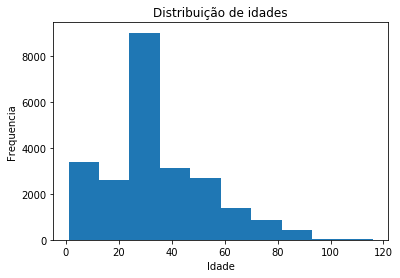

In [13]:
df['idade'].plot(kind='hist')
plt.title('Distribuição de idades')
plt.xlabel('Idade')
plt.ylabel('Frequencia')
plt.show()

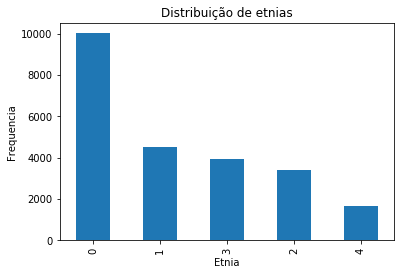

In [12]:
df['etnia'].value_counts().plot('bar')
plt.title('Distribuição de etnias')
plt.xlabel('Etnia')
plt.ylabel('Frequencia')
plt.show()

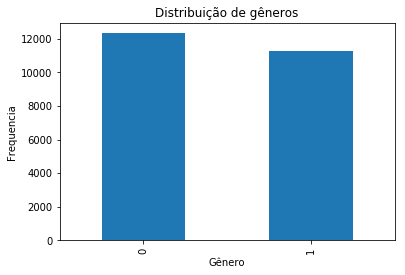

In [11]:
df['gênero'].value_counts().plot('bar')
plt.title('Distribuição de gêneros')
plt.xlabel('Gênero')
plt.ylabel('Frequencia')
plt.show()

### Processamento de imagens

#### Redução da dimensionalidade e remoção das cores

In [3]:
import numpy as np 
from PIL import Image

df['caminho_original'] = data_path + df['nome']

In [15]:
width_min = min(df['caminho_original'].apply(lambda nome: Image.open(nome).size[0]))
width_max = max(df['caminho_original'].apply(lambda nome: Image.open(nome).size[0]))
height_min = min(df['caminho_original'].apply(lambda nome: Image.open(nome).size[1]))
height_max = max(df['caminho_original'].apply(lambda nome: Image.open(nome).size[1]))

width_min,width_max,height_min,height_max

(200, 200, 200, 200)

In [4]:
size = (75,75)

def process_img(input_path):
    img = Image.open(input_path)
    img = img.resize((size[0],size[1]), Image.ANTIALIAS)
    img = img.convert('L')
    return img

df['imagem'] = df['caminho_original'].apply(process_img)

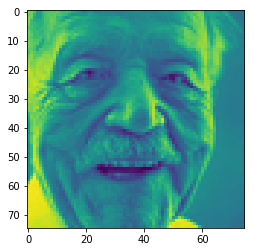

In [14]:
plt.imshow(df['imagem'][0])
plt.show()

### Separando uma pequena amostra dos dados para utilizar na apresentação

In [5]:
holdout_path = data_dir + 'holdout/'
holdout_percent = .005

holdout_df = df.sample(frac=holdout_percent, random_state=0)
df = df.drop(holdout_df.index)
holdout_df.apply(lambda row: row['imagem'].save(holdout_path+row['nome']),axis=1)

print(df.shape[0],holdout_df.shape[0])

del holdout_df

23586 119


### Dividindo o dataset para treinamento e teste


Para facilitar o processamento, os dados foram salvos com tags indicando o treinamento, validação e teste:<br>
0: Treinamento<br>
1: Validação <br>
2: Teste<br><br>

São 3 tags no total (uma para cada problema) e estão separadas do nome original do arquivo da seguinte maneira:<br>
**tagIdade.tagGenero.tagEtnia.idade_gênero_etnia_data&hora.jpg**<br>

Para dividir corretamente por "idade", é necessário criar intervalos que tenham uma quantidade equivalente de dados

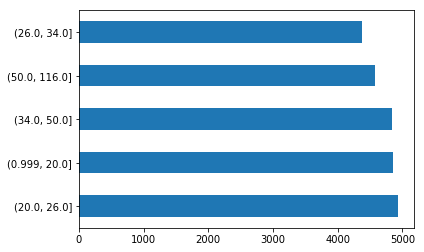

In [10]:
pd.qcut(df['idade'],5).value_counts().plot(kind='barh')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split 

valid_percent = .4
test_percent = .3

idade_q = 5

for column in ['idade','etnia','gênero']:
    
    stratify_target = df[column]
    if column == 'idade':
        stratify_target = pd.qcut(df['idade'],idade_q)
        
    X_train, X_val, y_train, y_val = train_test_split(
        df['nome'], 
        stratify_target, 
        test_size=valid_percent, 
        random_state=0,
        stratify=stratify_target)
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_val, 
        y_val, 
        test_size=test_percent, 
        random_state=0,
        stratify=y_val)

    split_dict = {
    }
    for index in y_train.index:
        split_dict[index] = 0
    for index in y_val.index:
        split_dict[index] = 1
    for index in y_test.index:
        split_dict[index] = 2

    df[column+'_split'] = df.apply(lambda row: split_dict[row.name],axis=1)

### Distribuições de treinamento, validação e teste

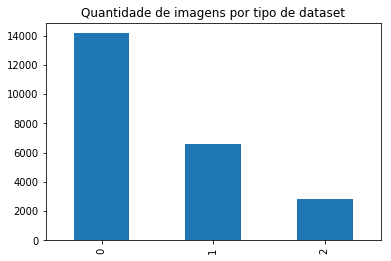

In [20]:
df['idade_split'].value_counts().plot('bar')
plt.title('Quantidade de imagens por tipo de dataset')
plt.show()

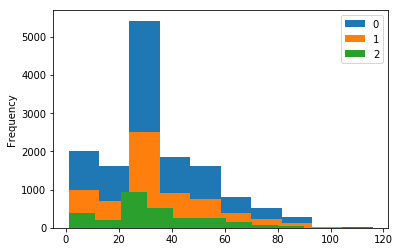

In [22]:
df.groupby('idade_split')['idade'].plot(kind='hist',legend=True)
plt.show()

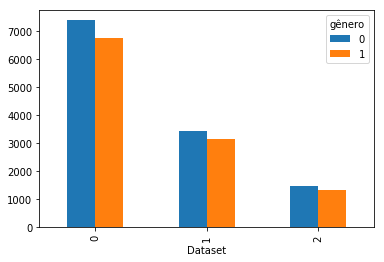

In [32]:
df.groupby('gênero_split')['gênero'].value_counts().unstack().plot(kind='bar',legend=True)
plt.xlabel('Dataset')
plt.show()

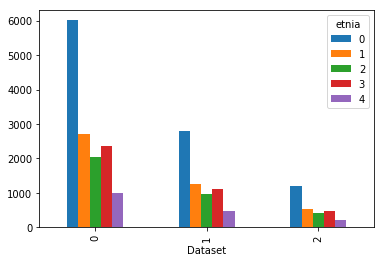

In [33]:
df.groupby('etnia_split')['etnia'].value_counts().unstack().plot(kind='bar',legend=True)
plt.xlabel('Dataset')
plt.show()

In [53]:
output_path = data_dir + 'train_test/'

df.apply(lambda row:row['imagem'].save("{}{}.{}.{}.{}".format(
    output_path,
    row['idade_split'],row['gênero_split'],row['etnia_split'],
    row['nome'])),
    axis=1)
print("Processamento concluído!")

Processamento concluído!
